# r1_model_simulations

### This notebook generates model simulations to illustrate group level behavioral effects
    
Ashwin G. Ramayya (ashwinramayya@gmail.com)
8/31/24
 
    
    

In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
from sklearn.metrics import r2_score,pairwise_distances
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 20
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/afig_r1/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
def clean_fig(apply_int=True):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],3))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],3))
    if apply_int==True:
        plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=20)
        plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)

  

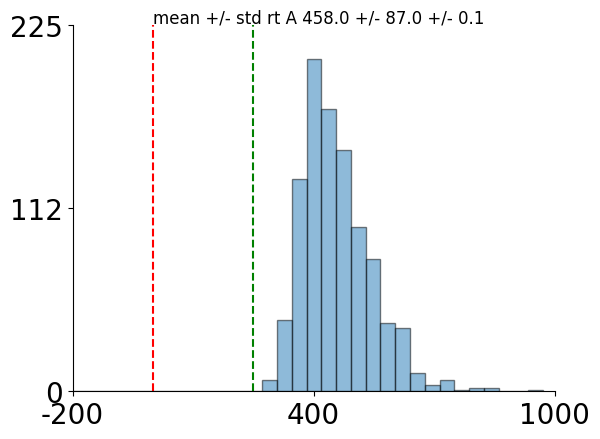

In [20]:
# We will model time in ms. Each trial begins at 0 and ends at 1500. 
# stimulus is presented at 500. response can occur from 500 to 1500.
# repsonse is generated via LATER, where a decision variable (DV) 
# reaches a response treshold. Rate of rise is determined by a Gaussian 
# We assume the starting point is 0 and the response threshold is 1
# RTs<500 are false alarms; these are triggered via an independent LATER process
# short delay trials and long delay trials are modeled 
# as different processes ('A' and 'B', with distinct LATER parameters)
# unfolding at the same time 

# initialize parameters
t1 = 500 # duration of pre S2 interval we are considering for false alarms
t2 = 1000 # duration of the post S2 interval we are considering

# LATER defaults
def getParams(bias_M=0, bias_S=0, bias_S0=0,bias_s0=0):
    # bias parameters indicate how to modify the long delay process 
    # bias_M alters the mean rate of rise
    # bias_S alters the std of the rate of rise
    # bias_S0 alters the starting point 
    # bias_s0 alters the starting point of the false alarm process
    
    params = {}
    params['St'] = 1 # response threshold
    params['S0_A'] = 0  # starting point
    params['M_A'] = 2.25#2.25 # rate of rise mean
    params['S_A'] = .4#.75 # std of rate of rise
    params['s0_A'] = 0  # starting point of false alarm process
    params['m_A'] = 1  # mean rate of rise of false alarm process
    params['s_A'] = .2  # std rate of rise of false alarm process
    
    
    params['S0_B'] = params['S0_A']+bias_S0  # starting point
    params['M_B'] = params['M_A']+ bias_M # rate of rise mean
    params['S_B'] = params['S_A']+ bias_S # std of rate of rise
    params['s0_B'] = params['s0_A']+bias_s0  # starting point of false alarm process
    params['m_B'] = params['m_A']  # mean rate of rise of false alarm process
    params['s_B'] = params['s_A']  # std rate of rise of false alarm process
    
    return params
params = getParams()
    
# function to simulate a trial (simulates A and B) 
def runTrial(params,plot_flag=False):
    
    # iniitalize RTs as nans
    RT_A = np.nan
    RT_B = np.nan
    
    # initialize containers for decision variables
    fv_a = np.zeros(t1)
    fv_b = np.zeros(t1)
    dv_a = np.zeros(t2)
    dv_b = np.zeros(t2)
    
    # initialize starting point
    fv_a[0] = params['s0_A']
    fv_b[0] = params['s0_B']
    dv_a[0] = params['S0_A']
    dv_b[0] = params['S0_B']
    
    # randomly draw rate of rise on this trial from a gaussian for A and B
    rng = np.random.default_rng()
    r_A = rng.normal(params['m_A'], params['s_A']) # rate of rise of A (short delay false alarms)
    r_B = rng.normal(params['m_B'], params['s_B']) # rate of rise of A (short delay false alarms)
    
    R_A = rng.normal(params['M_A'], params['S_A']) # rate of rise of A (short delay)
    R_B = rng.normal(params['M_B'], params['S_B']) # rate of rise of B (long delay)              
        
    # Model the rising process during the preS2 and post S2 interval
    # y = mx + b; y = 
    # we will represent time in seconds
    fv_a = r_A*(np.arange(0,t1)/1000) + params['s0_A']
    fv_b = r_B*(np.arange(0,t1)/1000) + params['s0_B']
    dv_a = R_A*(np.arange(0,t2)/1000) + params['S0_A']
    dv_b = R_B*(np.arange(0,t2)/1000) + params['S0_B']
    
    
    # check if we have triggered a false alarm
    if len(np.where(fv_a>=1)[0])>0:
        RT_A =np.where(fv_a>=1)[0][0]
    elif len(np.where(dv_a>=1)[0])>0:
        RT_A =np.where(dv_a>=1)[0][0]+500
    else:
        RT_A = np.nan # no response generated
        
        
        
        
    if len(np.where(fv_b>=1)[0])>0:
        RT_B =np.where(fv_b>=1)[0][0]
    elif len(np.where(dv_b>=1)[0])>0:
        RT_B =np.where(dv_b>=1)[0][0]+500
    else:
        RT_B = np.nan # no response generated
        
    # plot DV
    if plot_flag == True:
        
        plt.figure()
        plt.plot(np.arange(0,t1),fv_a)
        plt.plot(np.arange(t1,t1+t2),dv_a)
        plt.hlines([1],0,1500)
        plt.gca().set_ylim(-1,2)

        plt.figure()
        plt.plot(np.arange(0,t1),fv_b)
        plt.plot(np.arange(t1,t1+t2),dv_b)
        plt.hlines([1],0,1500)
        plt.gca().set_ylim(-1,2)
        
        """
        f = plt.figure()
        plt.plot(np.arange(0,ts),fv_a)
        plt.plot(np.arange(0,ts),fv_b)
        plt.plot(np.arange(0,te),dv_a)
        plt.plot(np.arange(0,te),dv_b)
        plt.hlines([0,1],0,1500)
        plt.gca().set_ylim(-1,2)
        """
              
    return RT_A,RT_B

#test the function above
#rt_a, rt_b = runTrial(params,plot_flag=True)
#print(rt_a)
#print(rt_b)

# function to simulate a subject 
def runSubj(params,num_trials=1000,plot_flag = False):
    rts_a =np.zeros(num_trials)
    rts_b =np.zeros(num_trials)
    for t in np.arange(1,num_trials):
        rts_a[t],rts_b[t] = runTrial(params,False)
        
    # calculate false alarms for  A and B 
    fa_a = np.sum(rts_a<=500)/num_trials
    fa_b = np.sum(rts_b<=500)/num_trials
    
    # calculate mean RT and std for A and B (excluding RTs<500)
    rtmean_a = np.nanmean(rts_a[rts_a>750])-500
    rtmean_b = np.nanmean(rts_b[rts_b>750])-500
    
    rtstd_a = np.nanstd(rts_a[rts_a>500])
    rtstd_b = np.nanstd(rts_b[rts_b>500])

    if plot_flag==True:    
        plt.figure()          
        # plot RTs for A and B
        plt.hist(rts_a-500,100,alpha=0.5);
        plt.hist(rts_b-500,100,alpha=0.5);
        plt.gca().set_xlim(-500,1000)
        
        # plot false alarms for A and B
        plt.figure()
        plt.plot([1,2],[fa_a,fa_b],marker='o',markersize = 10,linestyle='')
        plt.gca().set_ylim(0,1)
        plt.gca().set_xlim(.5,2.5)
        
        
        # plot mean RT for A and B
        plt.figure()
        plt.bar([1,2],[rtmean_a,rtmean_b])
        plt.gca().set_ylim(0,1000)
        plt.gca().text(1,1000,'mean +/- std rt A '+str(np.round(rtmean_a))\
                       +' +/- '+str(np.round(rtstd_a)))
        
    return rtmean_a,rtmean_b,fa_a,fa_b,rtstd_a,rtstd_b,rts_a,rts_b

#test the function above
params=getParams()
#params=getParams(bias_s0=.5,bias_S0=.2)
rtmean_a,rtmean_b,fa_a,fa_b,rtstd_a,rtstd_b,rts_a,rts_b=runSubj(params,plot_flag=False, num_trials=1000)

plt.figure()          
# plot RTs for A and B
plt.hist(rts_a-500,40,edgecolor='k',alpha=0.5);
plt.gca().set_xlim(-200,1000)
plt.gca().text(0,plt.gca().get_ylim()[1]+1,'mean +/- std rt A '+str(np.round(rtmean_a))\
               +' +/- '+str(np.round(rtstd_a))+' +/- '+str(fa_a*100),fontsize=12)
plt.gca().vlines((0,250),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color=('red','green'))
clean_fig()
save_fig('hist-RTsA-'+str(params))



In [88]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

-0.1
-0.08888888888888889
-0.07777777777777778
-0.06666666666666668
-0.05555555555555556
-0.044444444444444446
-0.03333333333333334
-0.022222222222222227
-0.011111111111111113
0.0
0.011111111111111113
0.022222222222222227
0.033333333333333326
0.04444444444444445
0.05555555555555555
0.06666666666666668
0.07777777777777778
0.08888888888888888
0.1
0.1111111111111111
0.12222222222222223
0.13333333333333333
0.14444444444444446
0.15555555555555559
0.16666666666666666
0.17777777777777778
0.1888888888888889
0.19999999999999998
0.2111111111111111
0.22222222222222224
0.23333333333333336
0.24444444444444444
0.25555555555555554
0.2666666666666667
0.2777777777777778
0.28888888888888886
0.30000000000000004
0.3111111111111111
0.3222222222222222
0.33333333333333337
0.34444444444444444
0.3555555555555555
0.3666666666666667
0.37777777777777777
0.38888888888888895
0.4
0.4111111111111112
0.4222222222222223
0.43333333333333335
0.44444444444444453
0.4555555555555556
0.4666666666666667
0.47777777777777786
0.

/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_62356/1287488605.py:142: RuntimeWarning: Mean of empty slice
  rtmean_b = np.nanmean(rts_b[rts_b>750])-500


0.7111111111111111
0.7222222222222223
0.7333333333333334
0.7444444444444445
0.7555555555555556
0.7666666666666667
0.7777777777777778
0.788888888888889
0.8
0.8111111111111111
0.8222222222222223
0.8333333333333334
0.8444444444444446
0.8555555555555556


/Users/ashwinramayya/Environments/ccdtenv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.8666666666666667
0.8777777777777779
0.888888888888889
0.9
0.9111111111111111
0.9222222222222224
0.9333333333333335
0.9444444444444445
0.9555555555555556
0.9666666666666667
0.9777777777777777
0.988888888888889
1.0


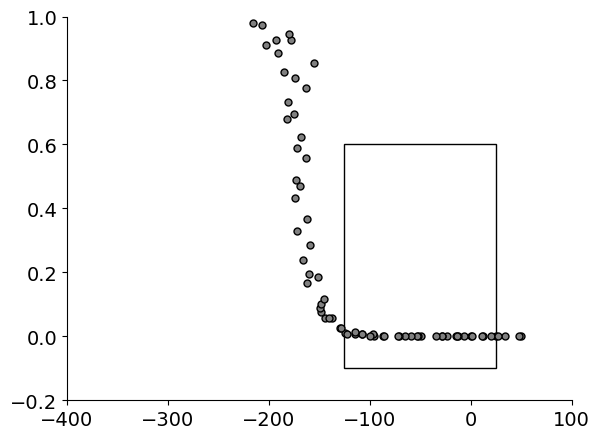

In [23]:
#make plots to explore the parameter space (and plot effects
# on delay-related changes in behavior)


# define parameter space
xvals = np.linspace(-.1,1,100)

#initialize container
rtdiff = np.zeros(xvals.shape[0])
fadiff = np.zeros(xvals.shape[0])

count=-1
for x in xvals:    
    count+=1
    # for each parameter, compute delay-relayed   
    # only change s0
    #params=getParams(bias_s0=x)
    #lbl='pres0-only'
    
    # only change S0
    #params=getParams(bias_S0=x)
    #lbl='postS0-only'
    
    # correlated changes in S0
    #params=getParams(bias_s0=x,bias_S0=x)
    #lbl ='s0-S0'
    rtmean_a,rtmean_b,fa_a,fa_b,rtstd_a,rtstd_b,rts_a,rts_b=runSubj(params,num_trials=1000,plot_flag=False)
      
    rtdiff[count]=rtmean_b-rtmean_a
    fadiff[count]=fa_b-fa_a
    print(x)
    
#f=plt.figure()
#plt.plot(xvals,rtdiff)

#f=plt.figure()
#plt.plot(xvals,fadiff)

from matplotlib.patches import Rectangle
f=plt.figure()
plt.plot(rtdiff,fadiff,'o',markeredgecolor='k',markerfacecolor='0.5',markersize=5)
plt.gca().add_patch(Rectangle((-125,-.1),150,0.7,facecolor='w',edgecolor='k'))
plt.gca().set_xlim(-400,100)
plt.gca().set_ylim(-.2,1)
save_fig(lbl)


# fix A parameters based on behavioral data
# define a parameter to change (e.g., mean B)
# quantify changes in delay-related RT changes and FA changes based on that parameter change
 

-0.1 -0.1
-0.05510204081632653 -0.1
-0.010204081632653059 -0.1
0.03469387755102041 -0.1
0.07959183673469389 -0.1
0.12448979591836737 -0.1
0.16938775510204082 -0.1
0.21428571428571433 -0.1
0.25918367346938775 -0.1
0.3040816326530612 -0.1
0.34897959183673477 -0.1
0.3938775510204082 -0.1
0.4387755102040817 -0.1
0.48367346938775513 -0.1
0.5285714285714287 -0.1
0.5734693877551021 -0.1
0.6183673469387756 -0.1
0.663265306122449 -0.1
0.7081632653061225 -0.1
0.7530612244897961 -0.1


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_62356/1287488605.py:142: RuntimeWarning: Mean of empty slice
  rtmean_b = np.nanmean(rts_b[rts_b>750])-500
/Users/ashwinramayya/Environments/ccdtenv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.7979591836734695 -0.1
0.842857142857143 -0.1
0.8877551020408164 -0.1
0.93265306122449 -0.1
0.9775510204081633 -0.1


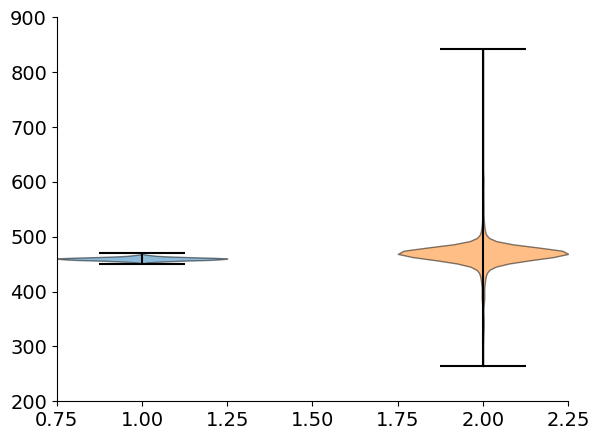

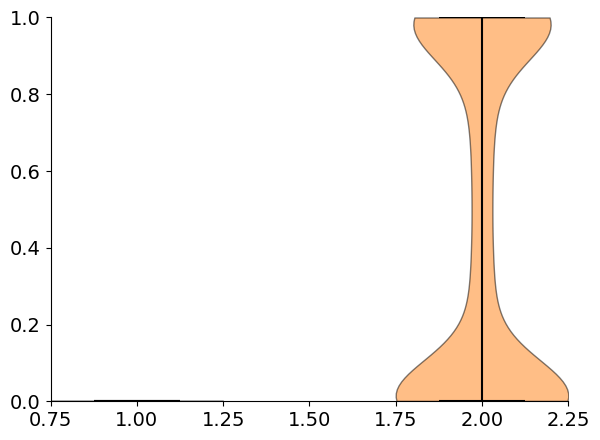

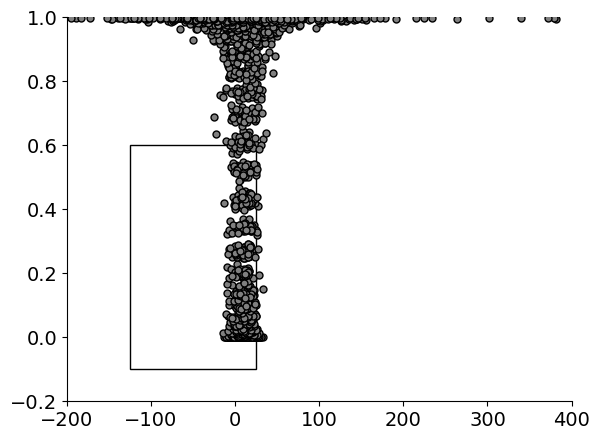

In [26]:
# plot Uncorrelated changes in starting points (FA vs. Mean)

# define parameter space
xvals = np.linspace(-.1,1,50)
yvals = np.linspace(-.1,1,50)
#initialize container

rta = np.zeros(xvals.shape[0]*xvals.shape[0])
rtb = np.zeros(xvals.shape[0]*xvals.shape[0])
rtdiff = np.zeros(xvals.shape[0]*xvals.shape[0])

faa = np.zeros(xvals.shape[0]*xvals.shape[0])
fbb = np.zeros(xvals.shape[0]*xvals.shape[0])
fadiff = np.zeros(xvals.shape[0]*xvals.shape[0])

count=-1
for x in xvals:
    for y in yvals:
        count+=1
        # for each parameter, compute delay-relayed
        # only change s0
        #params=getParams(bias_s0=x)
        

        # only change S0
        #params=getParams(bias_S0=x)

        # decorrelated changes in s0 and S0
        #params=getParams(bias_s0=x,bias_S0=y)
        #lbl='s0-S0-indep'

        # decorrelated changes in s0 and  M
        #params=getParams(bias_s0=x,bias_M=y)
        #lbl='s0-M-indep'        
        
        # decorrelated changes in  s0 and S
        params=getParams(bias_s0=x,bias_S=y)
        lbl='s0-S-indep'        
                
        rtmean_a,rtmean_b,fa_a,fa_b,rtstd_a,rtstd_b,rts_a,rts_b=runSubj(params,num_trials=1000,plot_flag=False)

        
        rta[count] = rtmean_a
        rtb[count] = rtmean_b
        faa[count] = fa_a
        fbb[count] = fa_b
        rtdiff[count]=rtmean_b-rtmean_a
        fadiff[count]=fa_b-fa_a
        
        if count%100 == 0:
            print(x,y)
        
        
def vplot(x,y,ylabel,cond_lbl,apply_int=True,col_list=['C0','C1']):
    f = plt.figure()
    ax = plt.subplot(111)
    vp = ax.violinplot((x[~np.isnan(x)],y[~np.isnan(y)]))
    for i in np.arange(0,len(vp['bodies'])):
        vp['bodies'][i].set_facecolor(col_list[i])
        vp['bodies'][i].set_edgecolor('k')
        vp['bodies'][i].set_alpha(0.5)
    vp['cmins'].set_color('k')
    vp['cbars'].set_color('k')
    vp['cmaxes'].set_color('k') 

vplot(rta,rtb,'mean RT (ms)',('',''))
save_fig(lbl+'-rt')        

vplot(faa,fbb,'False Alarm rate',('',''))
save_fig(lbl+'-fa')        

from matplotlib.patches import Rectangle
f = plt.figure()
plt.plot(rtdiff,fadiff,'o',markeredgecolor='k',markerfacecolor='0.5',markersize=5)
plt.gca().add_patch(Rectangle((-125,-.1),150,0.7,facecolor='w',edgecolor='k'))
#plt.fill_between(rtdiff,fadiff,alpha=0.6)
#plt.gca().set_ylim(-.1,0.6)
#plt.gca().set_xlim(-125,25)
save_fig(lbl+'-covar')        

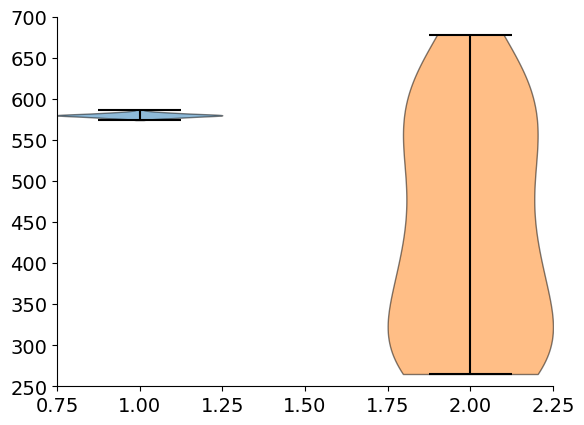

In [18]:
vplot(rta,rtb,'mean RT (ms)',('',''))

In [14]:
rtb

array([635.54108216, 567.09009009, 498.53853854, 424.78178178,
       354.16916917, 292.18941176, 266.97435897,          nan,
                nan,          nan, 638.06913828, 565.14114114,
       497.58358358, 422.86286286, 355.32532533, 293.8451688 ,
       268.33333333,          nan,          nan,          nan,
       635.6997992 , 563.58058058, 495.98798799, 425.09309309,
       353.23023023, 292.45626478, 269.3       ,          nan,
                nan,          nan, 634.2995992 , 567.15115115,
       495.18518519, 423.48748749, 354.5995996 , 291.27497062,
       271.12048193,          nan,          nan,          nan,
       640.45279188, 566.64314516, 497.22952477, 424.20242915,
       353.69238579, 292.77101096, 270.49425287,          nan,
                nan,          nan, 634.00226244, 572.56981982,
       497.37354988, 427.44239631, 354.57559682, 295.26575342,
       264.94117647,          nan,          nan,          nan,
       678.2       , 574.25      , 565.        , 391.  